In [2]:
import torch
import utils 
import math
import random
import helpers
import numpy as np 
import matplotlib as mlp
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder

# some useful functions

In [4]:
def compute_cvPCA(resp0):
    ss0 = utils.shuff_cvPCA(resp0, nshuff=10)
    ss0 = ss0.mean(axis=0)
    ss0 = ss0 / ss0.sum()

    return ss0

## Alexnet Model 

* get model architecture:

In [5]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()

Using cache found in /Users/duuta/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/duuta/.pyenv/versions/3.9.16/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/duuta/.pyenv/versions/3.9.16/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# define hook for intermediate activations

In [6]:
num_rois = 193600
num_stimulus = 2800
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def ghook(model, input, output):
    return intermediate_activations.append(output)

intermediate_activations = []

arr00 = np.empty((num_stimulus, num_rois), dtype=float)


## Using subset of ImageNet data, define transforms on data

In [7]:
batch_size = 1

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
         
            ]
        )

imagenet_data = ImageFolder('/Users/duuta/ppp/notebooks/robustSigs/ImageNet_data/imagenet-mini/', transform=transform)
imagenet_data2800 = Subset(imagenet_data, np.arange(2800))
data_loader = torch.utils.data.DataLoader(imagenet_data2800, 
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=10) 

num_epochs = int(len(imagenet_data2800)/ batch_size)

In [8]:
# features_list = [0, 3, 6, 8, 10]
# number of neurons 193600 
# set batch size and scale with 

In [24]:
sample_target_layer = model.features[0]
for epoch  in range(1000):
    for j, (input, _) in enumerate(iter(data_loader)):
        hook_handle = sample_target_layer.register_forward_hook(get_activation('feats'))
        _ = model(input)
        arr00[j, :] = activation['feats'].reshape(1, num_rois)

hook_handle.remove()

KeyboardInterrupt: 

* move imagenet data to nemo, computation cost is 1min/image 

In [9]:
arr00_image2K = arr00[:2800, :]

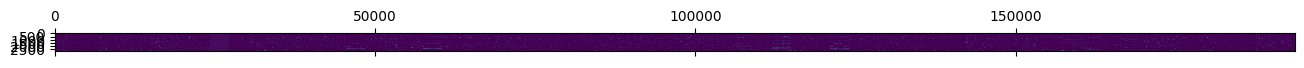

In [63]:
with mlp.rc_context({'figure.figsize': (20, 30)}):
    plt.matshow(arr00_image2K)

Text(0, 0.5, 'Stimulus Number')

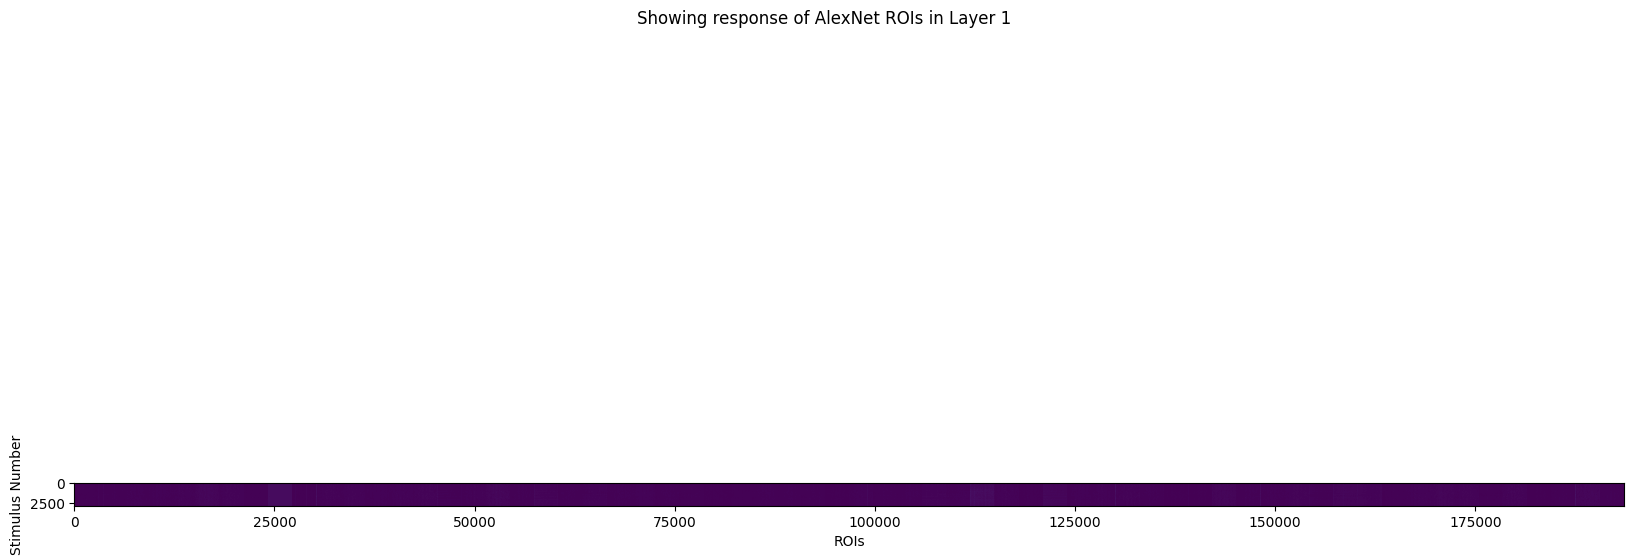

In [78]:
fig0 = plt.figure(figsize=(20, 10))
fig0.suptitle('Showing response of AlexNet ROIs in Layer 1')
ax = fig0.add_subplot()
plt.imshow(arr00_image2K)
ax.set_xlabel('ROIs')
jax.set_ylabel('Stimulus Number')

In [11]:
response = helpers.dupSignal(arr00_image2K, istm0)

In [12]:
response.shape

(2, 1400, 193600)

In [145]:
# create (2 * stim * neurons) 
# arr0  = helpers.ssplit(arr00_image2K)

In [97]:
def ssplit0(x):
    """Returns a new array of split
    spontaneous activity.
    (2, n, p)
    """
    # get # of stim
    nr = x.shape[0]
    snr = math.ceil(nr / 2)

    # get # neurons
    nco = x.shape[1]

    # init empty for final results
    newarr = np.empty((2, snr, nco))

    p0 = x[:snr, :]
    p1 = x[snr:nr, :]

    # store data
    newarr[0, :, :] = p0
    newarr[1, :, :] = p1

    return newarr

In [99]:
arr0 = ssplit0(arr00_image2K)

In [102]:
ss0 =compute_cvPCA(arr0)

In [13]:
ss0_ = compute_cvPCA(response)

/Users/duuta/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/duuta/ppp/notebooks/robustSigs/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  xproj = X[0].T @ (u / sv)
/Users/duuta/ppp/notebooks/robustSigs/utils.py:45: RuntimeWarning: invalid value encountered in divide
  xproj = X[0].T @ (u / sv)
/Users/duuta/ppp/notebooks/robustSigs/utils.py:45: RuntimeWarning: invalid value encountered in matmul
  xproj = X[0].T @ (u / sv)
/Users/duuta/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/duuta/ppp/notebooks/robustSigs/utils.py:45: RuntimeWarning: divide by zero encountered in divide
  xproj = X[0].T @ (u / sv)
/Users/duuta/ppp/notebooks/robustSigs/utils.py:4

In [139]:
ss0_.shape

(1400,)

In [140]:
alpha0, ypred0, _ = utils.get_powerlaw(ss0_/ss0.sum(), np.arange(11, 5e2).astype('int'))

In [141]:
alpha0

0.4829616676393982

# Using stimulus index (like in stringer)

In [3]:
with mlp.rc_context({'figure.figsize':(8, 6)}):
    
    plt.loglog(np.arange(0, ss0_.size)+1, ss0_/ss0_.sum())
    plt.loglog(np.arange(0, ss0_.size)+1, ypred0)
    plt.title("Plot of Variance drop Off by dimensions")
    plt.xlabel('Dimensions')
    plt.ylabel('Variance')

NameError: name 'ss0_' is not defined

# not using stringer computation 

In [115]:
ss00 = np.array(sorted(ss0))

In [124]:
alpha_value, ypred , _= utils.get_powerlaw(ss0/ss0.sum(), np.arange(11, 5e2).astype('int'))

In [125]:
alpha_value


0.4667129059518842

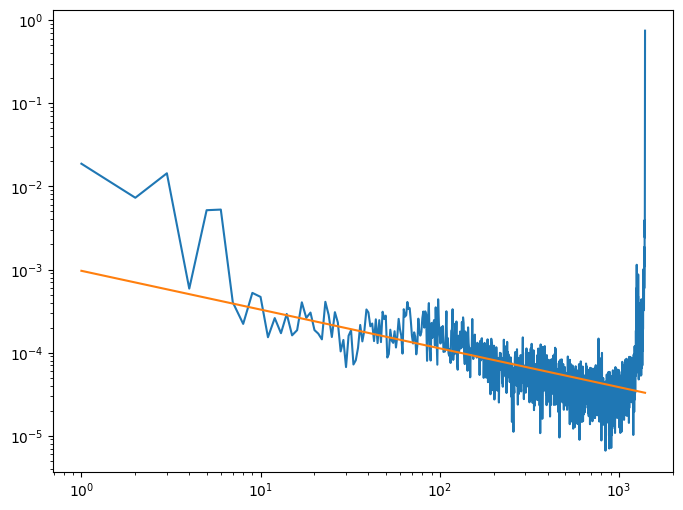

In [126]:
with mlp.rc_context({'figure.figsize': (8, 6)}):
    plt.loglog(np.arange(0, ss0.size)+1, ss0/ss0.sum())
    plt.loglog(np.arange(0, ss0.size)+1, ypred)


In [10]:
istm0 = np.concatenate((list(range(0, 1400)), list(range(0, 1400))))

* need to figure out dupSignal function, seems repeats responses are sought and averaged
* created stim index array [0, 1399]*2 in the other in which the stimulus was presented 
* results were not different from what I got splitting the data with ssplit. Also, alpha values were low 0.4777, 0.482,
* need to figure out what happens... NB: in stringer experiment repeat stimulus in alexnet, there are no repeats. 8
* these are important to create a 2* N * M stimulus and then compute cvPCA.
* I could pretend this is spontaneous activity and split the signal then procced
* extend the computation to next layers
* 